# Pixel-Based Mask ML

## Setup

In [1]:
from os.path import abspath, join
from os import listdir
import glob

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sn
plt.style.use('seaborn-deep')

from joblib import dump, load

from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split, cross_val_score

from sklearn import metrics
from sklearn.tree import export_graphviz
import pydot

In [2]:
path = {'root': abspath("/mnt/hgfs/Storage/Documents/Image Classification")}

path['data'] = join(path['root'], "Data")
path['model'] = join(path['root'], "Model")

## Import Data

In [3]:
# All contents in directory
listdir(path['data'])
datas = glob.glob(join(path['data'], "*.h5"))

datadict = {'global': {'index': 0, 'key': 'shpdf'}, 
            'fd': {'index': 1, 'key': 'shpdf_fd'}}

# Choose Data File
index, key = datadict['fd'].values()

datafile = datas[index]
datafile

'/mnt/hgfs/Storage/Documents/Image Classification/Data/data_fd.h5'

In [4]:
shpdf = pd.read_hdf(datafile, key)

## Visualisation Functions

In [5]:
# Confusion Matrix
def conf_matrix(test_set, predict_set, outpath, name=None, save=True):
    
    confm = metrics.confusion_matrix(test_set.values.argmax(axis=1), 
                                     predict_set.argmax(axis=1), 
                                     normalize='true')
    columns = test_set.columns

    df_cm = pd.DataFrame(confm, index=columns, columns=columns)

    plt.figure(figsize=[10]*2)
    ax = sn.heatmap(df_cm, cmap='Greens', annot=True, square=True, fmt='.1g', annot_kws={"size": 12})
    
    if save:
        if name is None:
            name = 'conf_mat.png'
        else:
            name = 'conf_mat_' + name + '.png'

        plt.savefig(join(outpath, name))
    
    return plt

In [6]:
def model_tree(model, feature_list, outpath, name=None):    
    
    if name is None:
        name = 'tree'
    else:
        name = 'tree_' + name
    
    outfile, outimg = join(outpath, name + '.dot'), join(outpath, name + '.png')
    
    # Pull out one tree from the forest
    tree = model.estimators_[5]
    
    # Export the image to a dot file
    export_graphviz(tree, out_file = outfile, feature_names = feature_list, rounded = True, precision = 1)
    
    # Use dot file to create a graph
    (graph, ) = pydot.graph_from_dot_file(outfile)
    
    # Write graph to a png file
    graph.write_png(outimg)
    
    return graph

In [7]:
def model_analysis(model, test_features, test_labels, predict_set, feature_list, 
                   name=None, graph=True, kfold=True, save=True):
    
    if kfold:
        scores = cross_val_score(model, test_features, test_labels, cv=5)
        print('K-Fold Cross Validation:\tMean: %.4f\tStd: %.4f' % (np.mean(scores), np.std(scores)))
    
    print('Accuracy Score:', metrics.accuracy_score(test_labels.values, predict_set))
    print('Classification Report:\n', metrics.classification_report(
        test_labels.values, predict_set, target_names=list(test_labels.columns)))

    conf_plt = conf_matrix(test_labels, predict_set, path['model'], name=name, save=save)
    conf_plt.show()
    
    if graph and save:
        graph = model_tree(model, feature_list, path['model'], name=name)
    
    return conf_plt, graph

In [8]:
def feature_importance_plot(model, X, figsize=(15, 20), name=None, save=True):
    
    # The impurity-based feature importances.
    ## The higher, the more important the feature. 
    
    ## The importance of a feature is computed as the (normalized)  
    ## total reduction of the criterion brought by that feature. 
    
    ## It is also known as the Gini importance.
    
    feature_imp = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
    
    # Creating a bar plot
    plt.figure(figsize=figsize)
    sn.barplot(x=feature_imp, y=feature_imp.index)

    # Add labels to your graph
    plt.xlabel('Feature Importance Score')
    plt.ylabel('Features')
    plt.title("Visualizing Important Features")
    
    if save:
        if name is None:
            name = 'feat_imp.png'
        else:
            name = 'feat_imp_' + name + '.png'

        plt.savefig(join(path['model'], name))
    
    return feature_imp, plt

## Pre-processing

In [9]:
def get_all_features_labels():
    X = shpdf[shpdf.columns.difference(['ess'])]
    y = pd.get_dummies(shpdf['ess'], prefix='ess')
    return X, y

In [10]:
X, y = get_all_features_labels()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

# Overview
print(list(zip(['X_train', 'X_test', 'y_train', 'y_test'], 
               map(lambda df: df.shape, [X_train, X_test, y_train, y_test])
              )))

X.describe()

[('X_train', (6731, 87)), ('X_test', (1683, 87)), ('y_train', (6731, 10)), ('y_test', (1683, 10))]


B11_1001     B11_1252     B11_1502     B11_1753     B11_2003  \
count  8414.000000  8414.000000  8414.000000  8414.000000  8414.000000   
mean      0.039992     0.117447     0.186322     0.197386     0.165273   
std       0.113863     0.183798     0.189300     0.163138     0.135191   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.012048     0.063166     0.050847   
50%       0.000000     0.011645     0.144982     0.175474     0.148515   
75%       0.003500     0.181159     0.288416     0.293233     0.250000   
max       0.968944     1.000000     1.000000     0.987013     0.887097   

          B11_2254      B11_250     B11_2504     B11_2755      B11_500  ...  \
count  8414.000000  8414.000000  8414.000000  8414.000000  8414.000000  ...   
mean      0.128258     0.000354     0.092688     0.065924     0.001291  ...   
std       0.124703     0.009436     0.116598     0.122538     0.014756  ...   
min       0.000000     0.000000     0.000000     0.000000     0.000000  ...   
25%       0.021422     0.000000     0.000000     0.000000     0.000000  ...   
50%       0.100000     0.000000     0.049813     0.013639     0.000000  ...   
75%       0.202681     0.000000     0.139785     0.079500     0.000000  ...   
max       0.913043     0.623907     0.966102     1.000000     0.590909  ...   

           GLCM_11      GLCM_12       GLCM_2         GLCM_3       GLCM_4  \
count  8414.000000  8414.000000  8414.000000    8414.000000  8414.000000   
mean     -0.613517     0.995259     0.593282    5292.444439     0.296208   
std       0.112783     0.010844     0.193045    5615.015673     0.163485   
min      -0.950000     0.711874    -0.403415      17.572523     0.002192   
25%      -0.701192     0.995500     0.471786    2438.681663     0.163598   
50%      -0.639039     0.998914     0.627027    4000.061604     0.279931   
75%      -0.532888     0.999684     0.745187    6399.803619     0.406789   
max      -0.175135     0.999996     0.942941  133314.143643     0.940999   

            GLCM_5         GLCM_6       GLCM_7       GLCM_8       GLCM_9  
count  8414.000000    8414.000000  8414.000000  8414.000000  8414.000000  
mean    195.494001   17067.982371     5.461094     6.731704     0.000460  
std      82.381029   19525.217628     0.778767     1.043252     0.000479  
min      15.035160      48.588977     0.852062     1.052722     0.000015  
25%     138.420624    7906.307840     5.118466     6.262025     0.000148  
50%     182.920392   12745.432403     5.580598     6.829140     0.000293  
75%     237.000491   20155.625067     5.932500     7.331652     0.000600  
max     811.598776  494063.388323     8.440623    10.613992     0.006013  

[8 rows x 87 columns]

## Hyperparameter Search Optimisations

In [11]:
def starting_model():
    return RandomForestClassifier(random_state=42, n_jobs=-1)
#     return MLPClassifier(verbose=True)

### Random Search

In [11]:
# Create the random grid
random_grid = {
    
    # Maximum number of levels in tree
    'max_depth': np.append(np.logspace(1, 2, num=7, base=10, dtype='int'), None), 

    'n_estimators': np.logspace(1, 3.3, num=12, base=10, dtype='int'), # Number of trees in random forest
    'max_features': ['sqrt', 'log2', None], # Number of features to consider at every split
    'min_samples_split': [2, 5, 10], # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4], # Minimum number of samples required at each leaf node
    'bootstrap': [True, False], # Method of selecting samples for training each tree
    'criterion': ['gini', 'entropy'], # Method of measuring the quality of a split
}

random_grid

{'max_depth': array([10, 14, 21, 31, 46, 68, 100, None], dtype=object),
 'n_estimators': array([  10,   16,   26,   42,   68,  111,  179,  290,  470,  761, 1232,
        1995]),
 'max_features': ['sqrt', 'log2', None],
 'min_samples_split': [2, 5, 10],
 'min_samples_leaf': [1, 2, 4],
 'bootstrap': [True, False],
 'criterion': ['gini', 'entropy']}

In [12]:
# Use the random grid to search for best hyperparameters
def model_random_search(search_grid, model, train_features, train_labels, n_iter=100, cv=5):

    # Random search of parameters, using k-fold cross validation, 
    # search across n_iter different combinations, and use all available cores
    random_model = RandomizedSearchCV(estimator = model, param_distributions = search_grid,
                                      n_iter=n_iter, cv=cv, verbose=2, random_state=42, n_jobs = -1)

    # Fit the random search model
    random_model.fit(train_features, train_labels)
    
    return random_model

In [137]:
model = starting_model()
search_model = model_random_search(random_grid, model, X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.0min
/home/tharen/miniconda3/envs/gis/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 43.3min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed: 139.3min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 217.2min finished


In [138]:
search_model.best_params_

{'n_estimators': 179,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': None,
 'max_depth': 14,
 'criterion': 'entropy',
 'bootstrap': False}

In [141]:
dump(search_model, join(path['model'], 'random_search.joblib'))

['/mnt/hgfs/Storage/Documents/Image Classification/Model/random_search.joblib']

In [12]:
random_search = load(join(path['model'], 'random_search.joblib'))
random_search

/home/tharen/miniconda3/envs/gis/lib/python3.6/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.22.2.post1 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/tharen/miniconda3/envs/gis/lib/python3.6/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.22.2.post1 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/tharen/miniconda3/envs/gis/lib/python3.6/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator RandomizedSearchCV from version 0.22.2.post1 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': array([10, 14, 21, 31, 46, 68, 100, None], dtype=object),
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': array([  10,   16,   26,   42,   68,  111,  179,  290,  470,  761, 1232,
       1995])},
                   random_state=42, verbose=2)

### Grid Search

In [13]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True, False],
    'max_depth': [10, 15, 20],
    'max_features': ['sqrt', None],
    'min_samples_leaf': [1, 2],
    'n_estimators': [100, 120, 140, 160, 180, 200]
}

In [14]:
# Create a based model
grid_model = starting_model()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = grid_model, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [16]:
# Fit the grid search to the data
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 144 candidates, totalling 432 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   28.2s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 11.6min
/home/tharen/miniconda3/envs/gis/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed: 35.2min
[Parallel(n_jobs=-1)]: Done 432 out of 432 | elapsed: 51.0min finished


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [True, False], 'max_depth': [10, 15, 20],
                         'max_features': ['sqrt', None],
                         'min_samples_leaf': [1, 2],
                         'n_estimators': [100, 120, 140, 160, 180, 200]},
             verbose=2)

In [17]:
grid_search.best_params_

{'bootstrap': False,
 'max_depth': 10,
 'max_features': None,
 'min_samples_leaf': 1,
 'n_estimators': 100}

In [19]:
dump(grid_search, join(path['model'], 'grid_search.joblib'))

['/mnt/hgfs/Storage/Documents/Image Classification/Model/grid_search.joblib']

In [ ]:
grid_search = load(join(path['model'], 'random_search.joblib'))
grid_search

### Final Chosen Model

In [11]:
def chosen_model():
    return RandomForestClassifier(random_state=42, 
                                  n_jobs=-1,
                                  n_estimators=100, 
                                  min_samples_split=2, 
                                  min_samples_leaf=1,
                                  max_features=None, 
                                  max_depth=10,
                                  criterion='gini',
                                  bootstrap=False)
#     return MLPClassifier(hidden_layer_sizes=[100,50,20], verbose=True)

## Learn Color Distribution

In [12]:
def learn_model(get_model, overfit=False, test_size=0.2, save=True, feat_imp=False):
    
    X, y = get_all_features_labels()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=y)
    
    model = get_model()
    model.fit(X_train, y_train)
    
    y_predict = model.predict(X_test)
    
    model_analysis(model, X_test, y_test, y_predict, X.columns, save=save)
    
    if overfit:
        print('Overfit Prediction Testing:')
        overfit_y_predict = model.predict(X_train)
        
        model_analysis(model, X_train, y_train, overfit_y_predict, X.columns, save=False, kfold=False)
    
    if feat_imp:
        _, plt = feature_importance_plot(model, X, save=save)
        plt.show()
    
    return model    

K-Fold Cross Validation:	Mean: 0.4468	Std: 0.0211
Accuracy Score: 0.47771836007130125
Classification Report:
               precision    recall  f1-score   support

 ess_1111100       0.51      0.42      0.46       106
 ess_1114111       0.36      0.22      0.27       123
 ess_1116000       0.53      0.37      0.44        62
 ess_1117000       0.50      0.11      0.18        53
 ess_1125000       0.80      0.84      0.82       556
 ess_1130000       0.26      0.13      0.18       135
 ess_1211000       0.74      0.63      0.68       146
 ess_1381100       0.41      0.31      0.35       183
 ess_2000000       0.25      0.13      0.17       139
 ess_4000000       0.39      0.29      0.33       180

   micro avg       0.60      0.48      0.53      1683
   macro avg       0.48      0.35      0.39      1683
weighted avg       0.55      0.48      0.50      1683
 samples avg       0.48      0.48      0.48      1683



/home/tharen/miniconda3/envs/gis/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


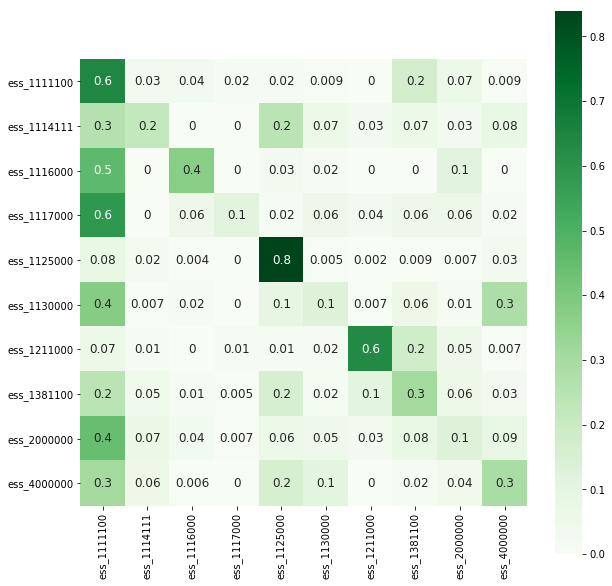

Overfit Prediction Testing:
Accuracy Score: 0.6839994057346606
Classification Report:
               precision    recall  f1-score   support

 ess_1111100       0.84      0.58      0.68       423
 ess_1114111       0.97      0.53      0.69       493
 ess_1116000       0.83      0.57      0.68       249
 ess_1117000       0.96      0.24      0.39       213
 ess_1125000       0.86      0.90      0.88      2221
 ess_1130000       0.89      0.42      0.58       542
 ess_1211000       0.93      0.86      0.90       584
 ess_1381100       0.83      0.64      0.72       732
 ess_2000000       0.88      0.48      0.62       555
 ess_4000000       0.77      0.60      0.67       719

   micro avg       0.86      0.68      0.76      6731
   macro avg       0.88      0.58      0.68      6731
weighted avg       0.87      0.68      0.75      6731
 samples avg       0.68      0.68      0.68      6731



/home/tharen/miniconda3/envs/gis/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


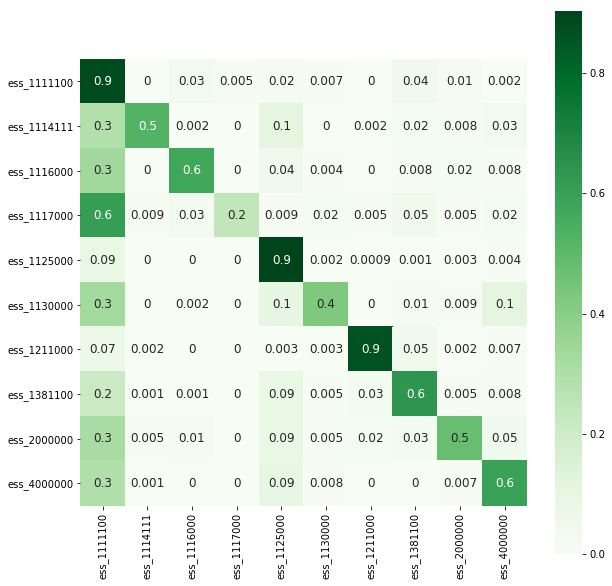

In [13]:
model = learn_model(chosen_model, overfit=True)

### Feature Importance

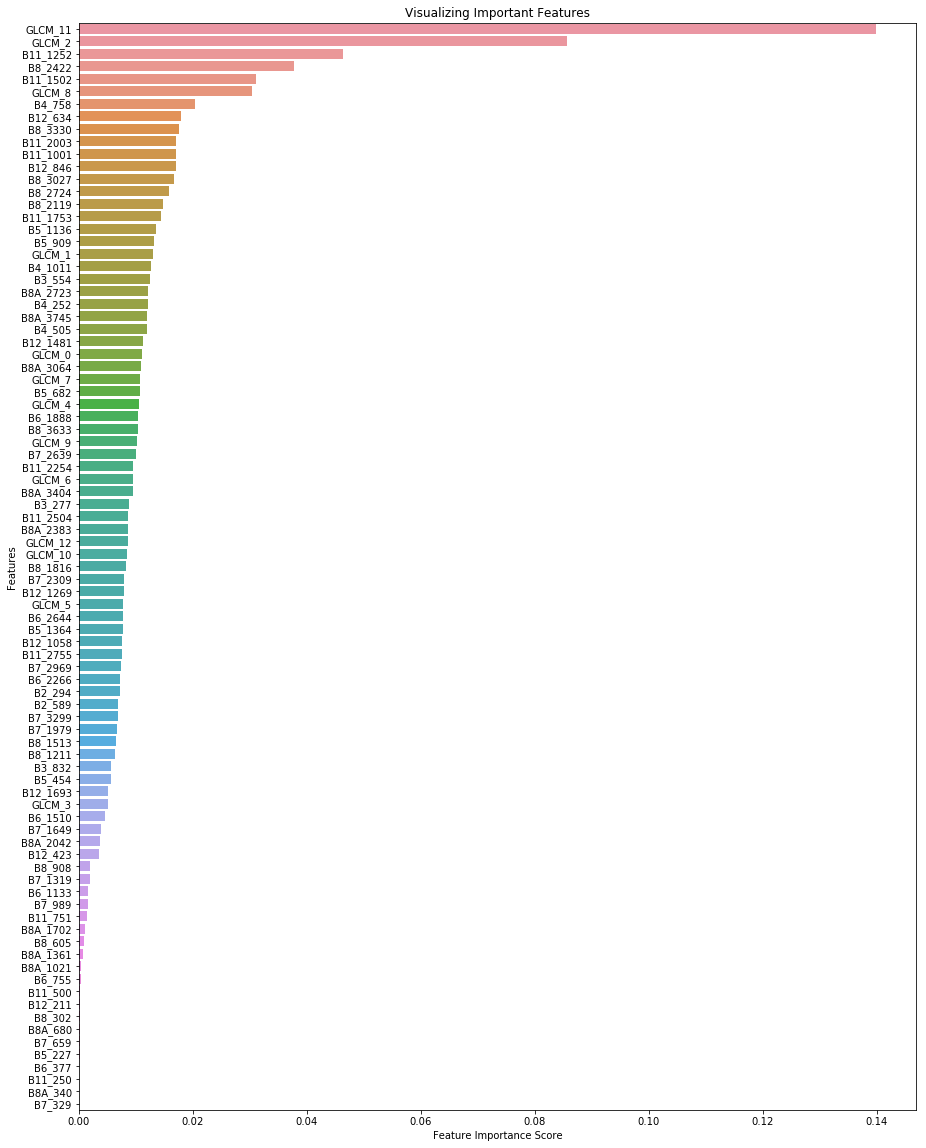

In [24]:
feature_imp, plt = feature_importance_plot(model, X)
plt.show()

In [25]:
f_imp = feature_imp[feature_imp > 0.00425].index
print(len(f_imp))
X[f_imp]

64


GLCM_11    GLCM_2  B11_1252   B8_2422  B11_1502    GLCM_8    B4_758  \
0    -0.842981  0.621128  0.000000  0.400000  0.000000  3.729846  0.300000   
1    -0.866678  0.452592  0.000000  0.000000  0.000000  4.226723  0.666667   
2    -0.572917  0.586555  0.062500  0.250000  0.562500  4.389792  0.093750   
3    -0.686930  0.582485  0.562500  0.187500  0.104167  5.507306  0.020833   
4    -0.631787  0.628967  0.000000  0.052632  0.000000  4.514287  0.000000   
...        ...       ...       ...       ...       ...       ...       ...   
8409 -0.377415  0.886009  0.022560  0.489040  0.321616  4.958689  0.015740   
8410 -0.405854  0.822495  0.012584  0.326577  0.225618  5.863841  0.096353   
8411 -0.380285  0.893134  0.061620  0.305203  0.366637  6.522791  0.049847   
8412 -0.399097  0.898744  0.052061  0.277150  0.463774  4.741894  0.022993   
8413 -0.378368  0.813428  0.008387  0.078970  0.634839  7.414040  0.041631   

       B12_634   B8_3330  B11_2003  ...    B2_589   B7_3299   B7_1979  \
0     0.000000  0.000000  0.200000  ...  0.300000  0.000000  0.200000   
1     0.000000  0.000000  0.333333  ...  0.666667  0.000000  0.933333   
2     0.375000  0.000000  0.062500  ...  0.062500  0.000000  0.468750   
3     0.708333  0.187500  0.000000  ...  0.063830  0.000000  0.062500   
4     0.000000  0.000000  0.000000  ...  1.000000  0.000000  0.842105   
...        ...       ...       ...  ...       ...       ...       ...   
8409  0.312697  0.006785  0.096013  ...  0.021008  0.000000  0.114823   
8410  0.195955  0.024775  0.136180  ...  0.134295  0.002248  0.076888   
8411  0.422418  0.018802  0.159331  ...  0.069523  0.001312  0.184958   
8412  0.688937  0.044309  0.054664  ...  0.031670  0.002169  0.015618   
8413  0.723760  0.254652  0.063011  ...  0.070863  0.170889  0.010520   

       B8_1513   B8_1211    B3_832    B5_454  B12_1693        GLCM_3   B6_1510  
0     0.100000  0.000000  0.300000  0.000000  0.000000   4689.464029  0.000000  
1     0.000000  0.000000  0.400000  0.000000  0.000000    828.166519  0.600000  
2     0.000000  0.000000  0.000000  0.000000  0.000000   2862.850557  0.437500  
3     0.020833  0.000000  0.042553  0.000000  0.000000   2908.570668  0.041667  
4     0.000000  0.000000  1.000000  0.000000  1.000000  16035.086539  0.184211  
...        ...       ...       ...       ...       ...           ...       ...  
8409  0.004697  0.000000  0.008929  0.000000  0.002623   3054.983705  0.016180  
8410  0.013514  0.007658  0.074410  0.000000  0.000000   3587.952320  0.038704  
8411  0.009620  0.001749  0.019239  0.000000  0.011429   2849.778223  0.042414  
8412  0.001738  0.000000  0.018221  0.000000  0.000000   2456.087194  0.003905  
8413  0.000433  0.000000  0.047515  0.007564  0.009229   3103.420588  0.000648  

[8414 rows x 64 columns]

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X[f_imp], y, test_size=0.2, stratify=y)

reduced_model, reduced_test_set, reduced_y_predict = default_training()

K-Fold Cross Validation: 0.47689786670284856
Accuracy Score: 0.47890671420083186
Classification Report:
               precision    recall  f1-score   support

 ess_1111100       0.44      0.35      0.39       106
 ess_1114111       0.34      0.28      0.31       123
 ess_1116000       0.45      0.37      0.41        62
 ess_1117000       0.39      0.25      0.30        53
 ess_1125000       0.77      0.78      0.77       556
 ess_1130000       0.27      0.22      0.24       135
 ess_1211000       0.73      0.57      0.64       146
 ess_1381100       0.37      0.30      0.33       183
 ess_2000000       0.33      0.25      0.28       139
 ess_4000000       0.37      0.34      0.36       180

   micro avg       0.54      0.48      0.51      1683
   macro avg       0.45      0.37      0.40      1683
weighted avg       0.53      0.48      0.50      1683
 samples avg       0.48      0.48      0.48      1683



/home/tharen/miniconda3/envs/gis/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


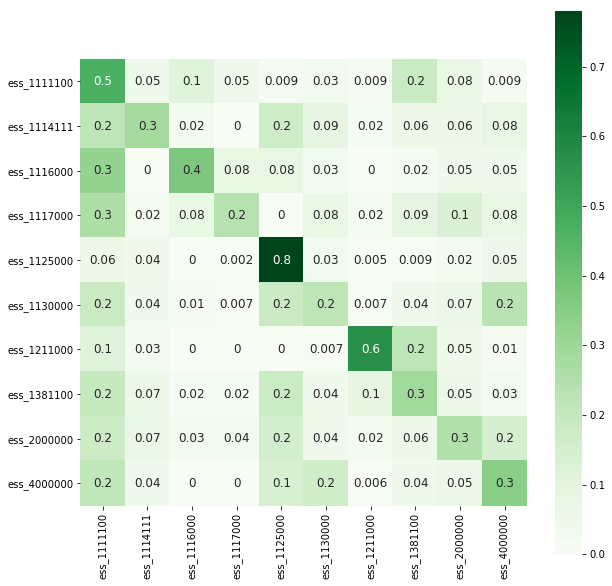

In [27]:
conf_plt_lim, graph_lim = model_analysis(reduced_model, reduced_test_set, reduced_y_predict, 
                                         X[f_imp].columns, name='reduced')
conf_plt_lim.show()

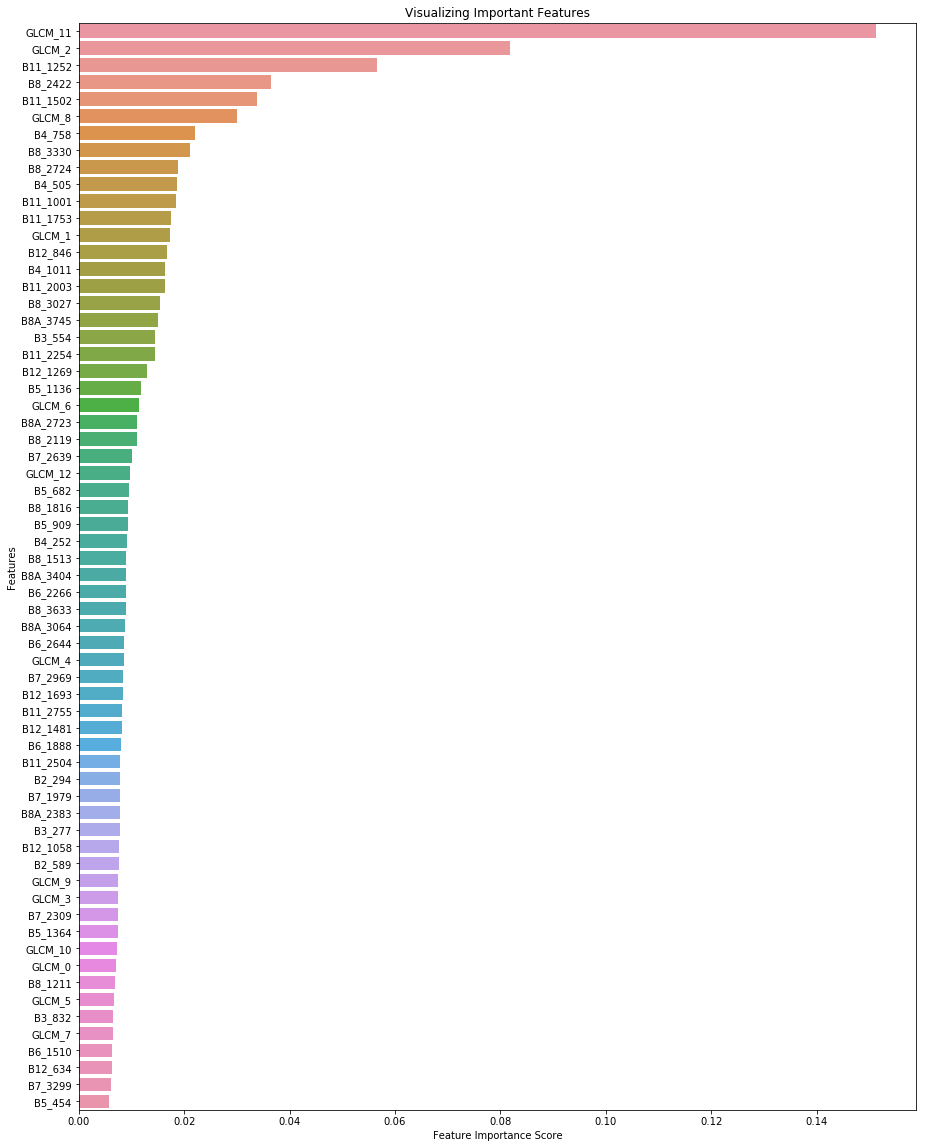

In [28]:
_, plt = feature_importance_plot(reduced_model, X[f_imp], name='reduced')
plt.show()